## Modelling

#### Importing packages and Libraries

In [1]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Library for Parallel Computing:  https://www.infoworld.com/article/3542595/6-python-libraries-for-parallel-processing.html

!pip install dask[dataframe]

In [3]:
#Downcasting so as to be memory Efficient
# Blog: https://medium.com/@deepakec1031/how-to-reduce-pandas-data-frame-size-using-downcast-e00cfed8e2c5

# install the package
!pip install downcast

In [4]:
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
import pandas as pd


import pickle
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import dask
import dask.dataframe as dd

In [5]:
import lightgbm as lgb

### Preparing the Data

In [6]:
# https://distributed.dask.org/en/latest/manage-computation.html
train_data1 = dd.read_csv("final_features")
train_data1 = train_data1.compute()
train_data1.drop('Unnamed: 0', axis = 1, inplace = True)
print("number of rows in train are {} and columns are {}".format(train_data1.shape[0], train_data1.shape[1]))
train_data1.head()

number of rows in train are 4867421 and columns are 152


,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_pz_high_alpha,eeg_f3_high_alpha,eeg_fz_high_alpha,eeg_f4_high_alpha,eeg_c4_high_alpha,eeg_p4_high_alpha,eeg_poz_high_alpha,eeg_c3_high_alpha,eeg_cz_high_alpha,eeg_o2_high_alpha
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,...,0.000711,0.006475,0.001546,0.003503,0.004798,0.002157,0.001501,0.005812,0.002571,0.002405
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,...,0.000694,0.006458,0.001845,0.003975,0.005096,0.002182,0.001486,0.005788,0.002614,0.002387
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,...,0.000679,0.006442,0.002136,0.004439,0.005382,0.002207,0.001472,0.005767,0.002656,0.002372
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,...,0.000668,0.006430,0.002420,0.004895,0.005659,0.002230,0.001460,0.005749,0.002697,0.002359
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,...,0.000659,0.006419,0.002696,0.005342,0.005925,0.002252,0.001450,0.005733,0.002738,0.002347


In [7]:
# Blog: https://medium.com/@deepakec1031/how-to-reduce-pandas-data-frame-size-using-downcast-e00cfed8e2c5
from downcast import reduce

train_data1 = reduce(train_data1) 

In [8]:
#remove some feature that shows no effect in EDA Analysis and also Target Variables

# https://numpy.org/doc/stable/reference/generated/numpy.unique.html

X = train_data1.drop(['crew', 'experiment', 'time', 'seat', 'event', 'event1'], axis = 1)

y = train_data1['event1']

In [9]:
#all columns in train and Test
features_lst = X.columns
print(features_lst[: 5])

Index(['eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6'], dtype='object')


In [10]:
del train_data1

In [11]:
# split the data into test and train by maintaining same distribution of output varaible 'y' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify = y, test_size=0.20)


# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify = y_train, test_size = 0.20)



print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

print("Number of Unique Values in y_train: ", np.unique(y_train,return_counts=True))

Number of data points in train data: 3115148
Number of data points in test data: 973485
Number of data points in cross validation data: 778788
Number of Unique Values in y_train:  (array([0, 1, 2, 3], dtype=int8), array([1823237, 1057718,  150610,   83583]))


In [12]:
del X, y

<IPython.core.display.Javascript object>


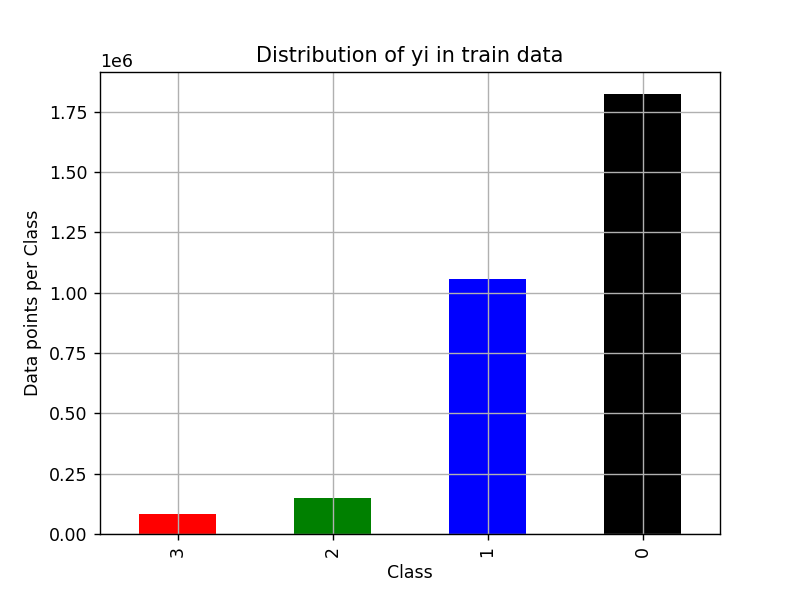

Number of data points in class 0 : 1823237 ( 58.528 %)
Number of data points in class 1 : 1057718 ( 33.954 %)
Number of data points in class 2 : 150610 ( 4.835 %)
Number of data points in class 3 : 83583 ( 2.683 %)
--------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


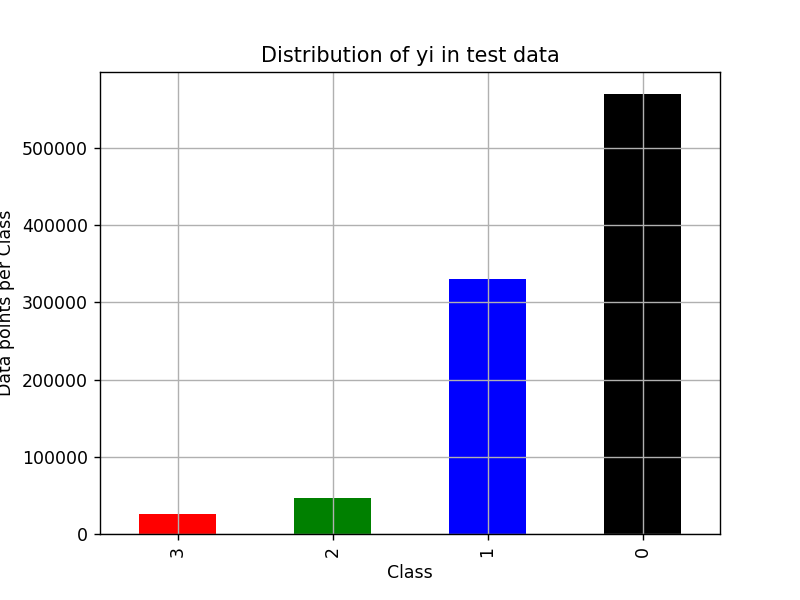

Number of data points in class 0 : 569762 ( 58.528 %)
Number of data points in class 1 : 330538 ( 33.954 %)
Number of data points in class 2 : 47066 ( 4.835 %)
Number of data points in class 3 : 26119 ( 2.683 %)
--------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


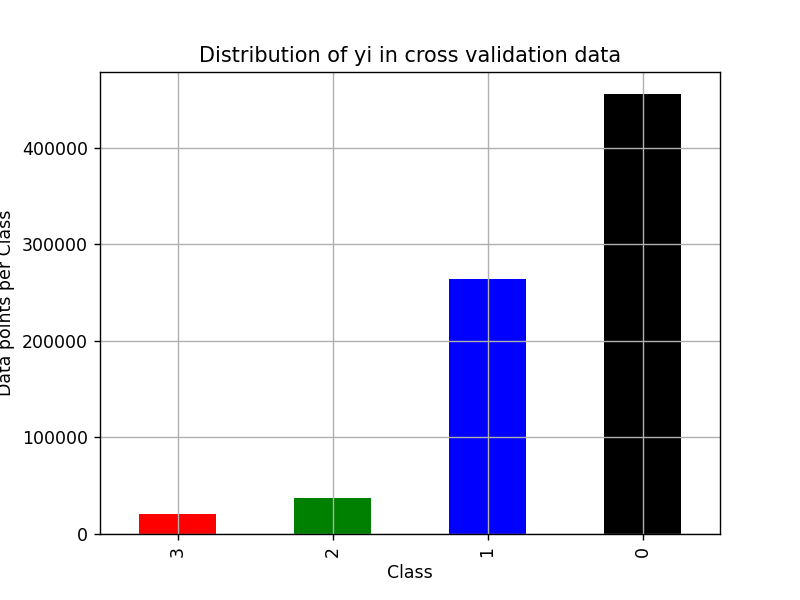

Number of data points in class 0 : 455810 ( 58.528 %)
Number of data points in class 1 : 264430 ( 33.954 %)
Number of data points in class 2 : 37653 ( 4.835 %)
Number of data points in class 3 : 20895 ( 2.683 %)


In [13]:
#Taken Reference from Microsoft Malware Detection

# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = y_train.value_counts().sort_values()
test_class_distribution = y_test.value_counts().sort_values()
cv_class_distribution = y_cv.value_counts().sort_values()

my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', 3 - i, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/y_train.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', 3 - i, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/y_test.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
cv_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', 3 - i, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/y_cv.shape[0]*100), 3), '%)')


In [13]:
from sklearn.preprocessing import MinMaxScaler

# https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/
# https://stackoverflow.com/questions/43675665/when-scale-the-data-why-the-train-dataset-use-fit-and-transform-but-the-te


min_max_scaler = MinMaxScaler()


X_train = min_max_scaler.fit_transform(X_train)
X_cv = min_max_scaler.transform(X_cv)
X_test = min_max_scaler.transform(X_test)

- Loading AutoEncoders Fearures

In [14]:
# loading the encoder model which we have Saved
from tensorflow.keras.models import load_model

encoder = load_model('finalencoder_compression.h5')

In [15]:
# encode the train data
X_train_encode_features = encoder.predict(X_train)

# encode the cv data
X_cv_encode_features = encoder.predict(X_cv)


# encoding the test data
X_test_encode_features = encoder.predict(X_test)

In [16]:
#Merging all previous features with the new Encoded Features

#first Getting all features names

encoded_features_names = []

for i in range(X_train_encode_features.shape[1]):
    feature_name = 'encoded' + str(i + 1)
    encoded_features_names.append(feature_name)

print(encoded_features_names)

['encoded1', 'encoded2', 'encoded3', 'encoded4', 'encoded5', 'encoded6', 'encoded7', 'encoded8', 'encoded9', 'encoded10', 'encoded11', 'encoded12', 'encoded13', 'encoded14', 'encoded15', 'encoded16', 'encoded17', 'encoded18', 'encoded19', 'encoded20']


In [17]:
# creating the dataframe for Train
X_train_encoded_df = pd.DataFrame(data = X_train_encode_features,  columns = encoded_features_names) 
  
# displaying the dataframe 
X_train_encoded_df.head()

,encoded1,encoded2,encoded3,encoded4,encoded5,encoded6,encoded7,encoded8,encoded9,encoded10,encoded11,encoded12,encoded13,encoded14,encoded15,encoded16,encoded17,encoded18,encoded19,encoded20
0,0.009546,0.050603,0.089094,0.015108,-0.111910,0.048537,-0.116067,0.032693,0.046786,-0.038033,-0.064501,-0.048339,-0.006755,-0.000161,-0.057267,0.055526,-0.005482,-0.023545,-0.033791,-0.064421
1,-0.053973,0.137925,0.018065,0.098995,-0.107884,0.121941,-0.066678,0.004319,-0.050664,-0.043099,-0.026269,-0.019732,0.027637,-0.058463,-0.019450,-0.008226,-0.023991,0.028713,0.066076,-0.031798
2,0.036648,-0.006484,-0.004166,-0.079306,-0.046977,0.051166,0.033131,-0.003589,0.075852,0.070009,0.026869,0.040666,-0.001033,-0.051693,-0.091342,0.027741,0.127674,-0.017965,0.048968,0.092269
3,0.003251,0.028893,0.120128,-0.019862,-0.031424,0.071374,-0.082173,0.017442,0.060236,-0.044465,-0.014276,0.071268,0.020704,0.141358,-0.031650,0.016553,0.049461,0.012419,0.067934,0.043141
4,0.011727,-0.050522,0.014956,0.056319,0.051487,0.011850,-0.020199,0.058201,0.066177,0.013691,0.044864,0.098365,-0.022388,0.064358,0.097672,0.029857,0.039047,0.050675,0.063567,0.045478


In [18]:
# creating the dataframe for CV
X_cv_encoded_df = pd.DataFrame(data = X_cv_encode_features,  columns = encoded_features_names) 
  
# displaying the dataframe 
X_cv_encoded_df.head()

,encoded1,encoded2,encoded3,encoded4,encoded5,encoded6,encoded7,encoded8,encoded9,encoded10,encoded11,encoded12,encoded13,encoded14,encoded15,encoded16,encoded17,encoded18,encoded19,encoded20
0,-0.016219,0.138757,-0.126062,-0.050863,0.042417,0.039191,-0.040546,0.036443,0.019181,-0.030048,-0.082606,0.059308,-0.012374,-0.043852,-0.034139,-0.047347,-0.112378,-0.070908,0.018046,0.008931
1,0.017216,-0.027499,0.058964,-0.068652,-0.002802,0.058376,0.018373,-0.002275,0.002697,-0.011484,0.031462,0.016061,0.099551,0.005911,-0.022054,0.023024,0.034247,0.048642,-0.023384,-0.043757
2,-0.051890,-0.029077,-0.001712,-0.008026,-0.043104,0.030313,0.015625,-0.038781,-0.028799,-0.126251,0.040628,-0.062925,0.120202,0.130118,0.022674,-0.116410,0.031503,0.065066,-0.025550,-0.103384
3,0.275636,-0.194729,-0.157599,-0.056073,-0.016408,0.079235,-0.177839,0.027583,-0.353841,0.231672,0.234724,-0.065092,0.053316,-0.235220,-0.265214,0.225774,0.157157,-0.039129,0.022656,0.357609
4,-0.055428,0.071281,-0.069273,-0.026152,0.100989,-0.006537,-0.012681,0.016615,0.045488,-0.014976,0.027892,0.149561,-0.000789,0.112460,0.002624,-0.065193,-0.069366,-0.037324,0.081851,0.005990


In [19]:
# creating the dataframe for test
X_test_encoded_df = pd.DataFrame(data = X_test_encode_features,  columns = encoded_features_names) 
  
# displaying the dataframe 
X_test_encoded_df.head()

,encoded1,encoded2,encoded3,encoded4,encoded5,encoded6,encoded7,encoded8,encoded9,encoded10,encoded11,encoded12,encoded13,encoded14,encoded15,encoded16,encoded17,encoded18,encoded19,encoded20
0,0.062709,0.041761,-0.042986,-0.003476,-0.040586,-0.085047,0.029102,0.050378,0.013287,-0.057992,-0.076893,0.058134,0.017770,-0.082652,-0.101978,0.071526,-0.074503,-0.041163,-0.000584,-0.058438
1,-0.022234,0.014826,-0.105898,0.022549,0.030872,-0.035993,-0.058076,-0.017211,0.032182,-0.026390,0.047376,0.022097,-0.001836,-0.037450,-0.051643,-0.042982,-0.067658,-0.012073,0.051693,0.055409
2,-0.028990,0.005572,-0.025149,-0.060897,-0.023966,0.084443,-0.069338,0.075729,0.063287,-0.025767,0.065246,-0.016600,-0.043792,0.058873,-0.028694,-0.055291,0.079050,0.014190,0.092155,0.019989
3,-0.043378,0.101066,-0.076966,0.128100,-0.021545,-0.057382,0.107099,0.027710,0.025743,-0.099069,0.091079,-0.013888,-0.023603,-0.003991,0.058503,0.040947,0.076898,0.014624,0.081871,-0.048422
4,0.030436,0.048069,-0.002089,-0.090218,0.035896,-0.002008,-0.016893,0.088466,-0.001139,-0.085453,0.082685,0.084362,0.056658,-0.088798,0.079428,0.033741,0.047775,0.016807,-0.019776,0.042349


In [20]:
del X_test_encode_features
del X_train_encode_features
del X_cv_encode_features

In [21]:
#Converting numpy ndarray train into dataframe

X_train_df = pd.DataFrame(data = X_train,  columns = features_lst) 
X_cv_df = pd.DataFrame(data = X_cv, columns = features_lst)
X_test_df = pd.DataFrame(data = X_test, columns = features_lst)
  
# displaying the dataframe 
X_train_df.head()

,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,...,eeg_pz_high_alpha,eeg_f3_high_alpha,eeg_fz_high_alpha,eeg_f4_high_alpha,eeg_c4_high_alpha,eeg_p4_high_alpha,eeg_poz_high_alpha,eeg_c3_high_alpha,eeg_cz_high_alpha,eeg_o2_high_alpha
0,0.411865,0.439453,0.437012,0.468018,0.583008,0.516602,0.458252,0.407715,0.609375,0.572754,...,0.034424,0.027771,0.079163,0.028259,0.019135,0.008308,0.014832,0.017441,0.047424,0.053467
1,0.415527,0.441406,0.436523,0.467529,0.575684,0.522949,0.462402,0.407959,0.605469,0.568848,...,0.076416,0.088501,0.117615,0.039917,0.036346,0.026550,0.034668,0.054199,0.117371,0.056641
2,0.407471,0.437500,0.437012,0.465088,0.575684,0.518555,0.455811,0.401855,0.604004,0.566895,...,0.100403,0.041138,0.119019,0.042725,0.020737,0.016556,0.034210,0.027832,0.141357,0.059906
3,0.407471,0.436523,0.440430,0.483643,0.572266,0.520508,0.461182,0.402832,0.606934,0.572266,...,0.032288,0.079529,0.080200,0.028503,0.014648,0.026840,0.024078,0.022614,0.075989,0.056488
4,0.406494,0.435791,0.433350,0.460693,0.574219,0.517090,0.457275,0.403564,0.604004,0.566406,...,0.121643,0.031891,0.118652,0.030334,0.033661,0.019150,0.013565,0.033813,0.097229,0.058441


In [22]:
del  X_train
del X_cv
del X_test

In [23]:
#merging all the features train

X_train_total_features = pd.concat([X_train_df, X_train_encoded_df], axis = 1)
print(X_train_total_features.shape)

#merging all the Features cv
X_cv_total_features = pd.concat([X_cv_df, X_cv_encoded_df], axis = 1)
print(X_cv_total_features.shape)


#merging all the Features test
X_test_total_features = pd.concat([X_test_df, X_test_encoded_df], axis = 1)
print(X_test_total_features.shape)

(3115148, 166)
(778788, 166)
(973485, 166)


In [24]:
X_train_total_features = reduce(X_train_total_features)

In [25]:
X_cv_total_features = reduce(X_cv_total_features)

In [26]:
X_test_total_features = reduce(X_test_total_features)

In [27]:
del X_train_df
del X_cv_df
del X_test_df

In [28]:
del  X_train_encoded_df
del  X_cv_encoded_df
del X_test_encoded_df

#### Confusion Matrix: 

https://machinelearningmastery.com/confusion-matrix-machine-learning/#:~:text=A%20confusion%20matrix%20is%20a,two%20classes%20in%20your%20dataset.


In [32]:
#This code is taken from microsoft case study

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 4,4 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
   

    labels = [0,1,2,3]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    B =(C/C.sum(axis=0))
    
    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

<h1>Machine Learning Models</h1>

### 1. Logistic Regression

**Hyperparameter Tuning**

{} Alpha Completed 1e-05
{} Alpha Completed 0.0001
{} Alpha Completed 0.001
{} Alpha Completed 0.01
{} Alpha Completed 0.1
{} Alpha Completed 1
{} Alpha Completed 10
{} Alpha Completed 100
{} Alpha Completed 1000
{} Alpha Completed 10000
log_loss for c =  1e-05 is 0.9122530557733454
log_loss for c =  0.0001 is 0.9088308196402467
log_loss for c =  0.001 is 0.9039444677139867
log_loss for c =  0.01 is 0.9037686153577275
log_loss for c =  0.1 is 0.9047550926807036
log_loss for c =  1 is 0.9049550045168866
log_loss for c =  10 is 0.9047842613533762
log_loss for c =  100 is 0.9057454908198086
log_loss for c =  1000 is 0.9052822580789538
log_loss for c =  10000 is 0.9049969415155202
0.01


<IPython.core.display.Javascript object>


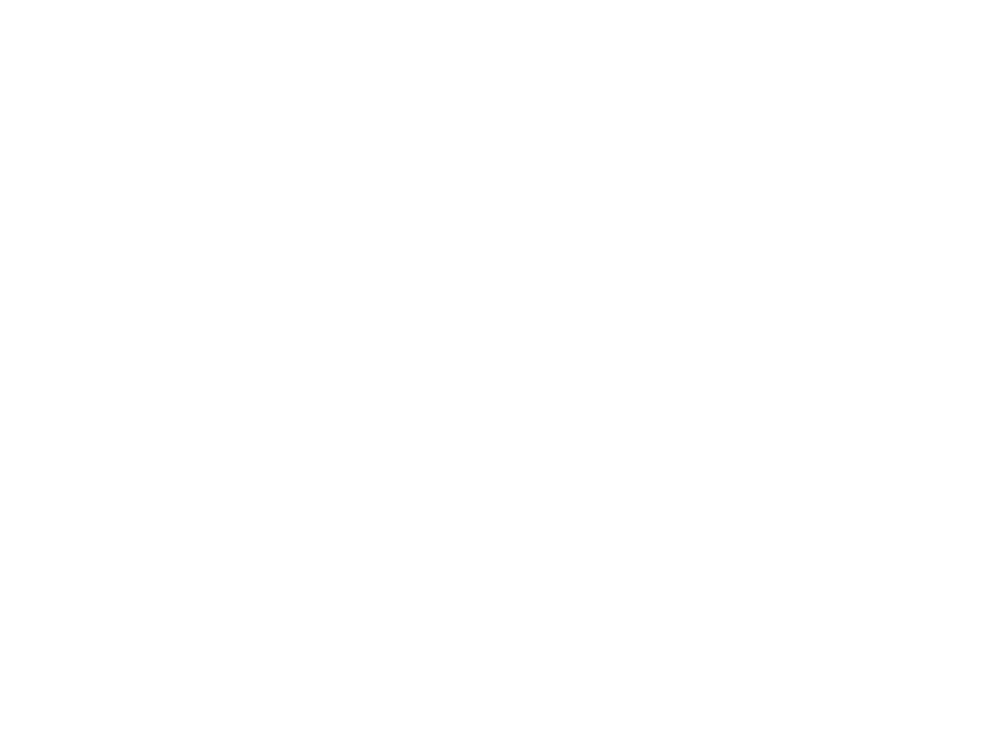

In [31]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#getting Different alpha Values
alpha = [10 ** x for x in range(-5, 5)]

#storing all the loss values of cv in a array
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train_total_features,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train_total_features, y_train)
    predict_y = sig_clf.predict_proba(X_cv_total_features)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
    #print("{} Alpha Completed", i)

log_loss for c =  1e-05 is 0.9122530557733454
log_loss for c =  0.0001 is 0.9088308196402467
log_loss for c =  0.001 is 0.9039444677139867
log_loss for c =  0.01 is 0.9037686153577275
log_loss for c =  0.1 is 0.9047550926807036
log_loss for c =  1 is 0.9049550045168866
log_loss for c =  10 is 0.9047842613533762
log_loss for c =  100 is 0.9057454908198086
log_loss for c =  1000 is 0.9052822580789538
log_loss for c =  10000 is 0.9049969415155202
0.01


<IPython.core.display.Javascript object>


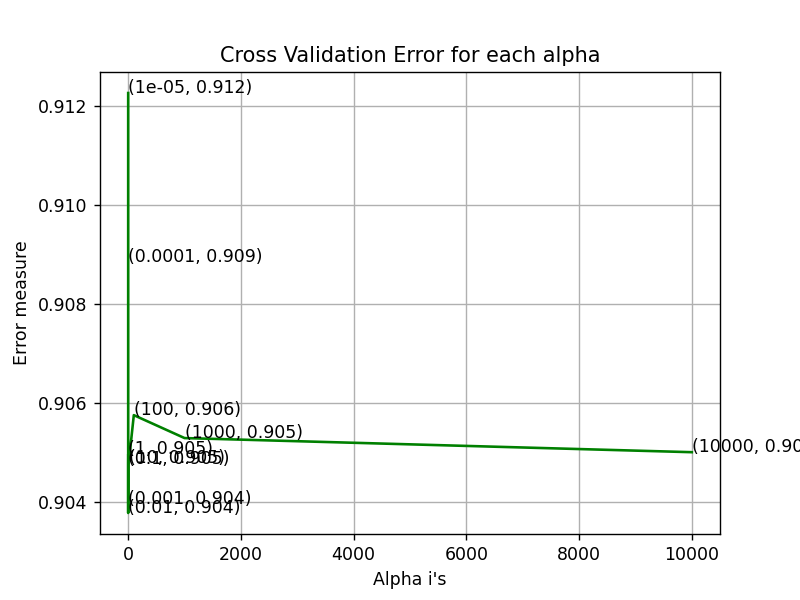

In [32]:
#printing all alphas and their loss values respectively
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


#Selecting Best Alpha
best_alpha = np.argmin(cv_log_error_array)
print(alpha[best_alpha])
    
# Plotting the loss values with respect to alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#### Training the Model with Best Parameters

log loss for train data 0.9038859341159958
log loss for cv data 0.9037686153577275
log loss for test data 0.9037356689536634
Number of misclassified points  41.502231672804406
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


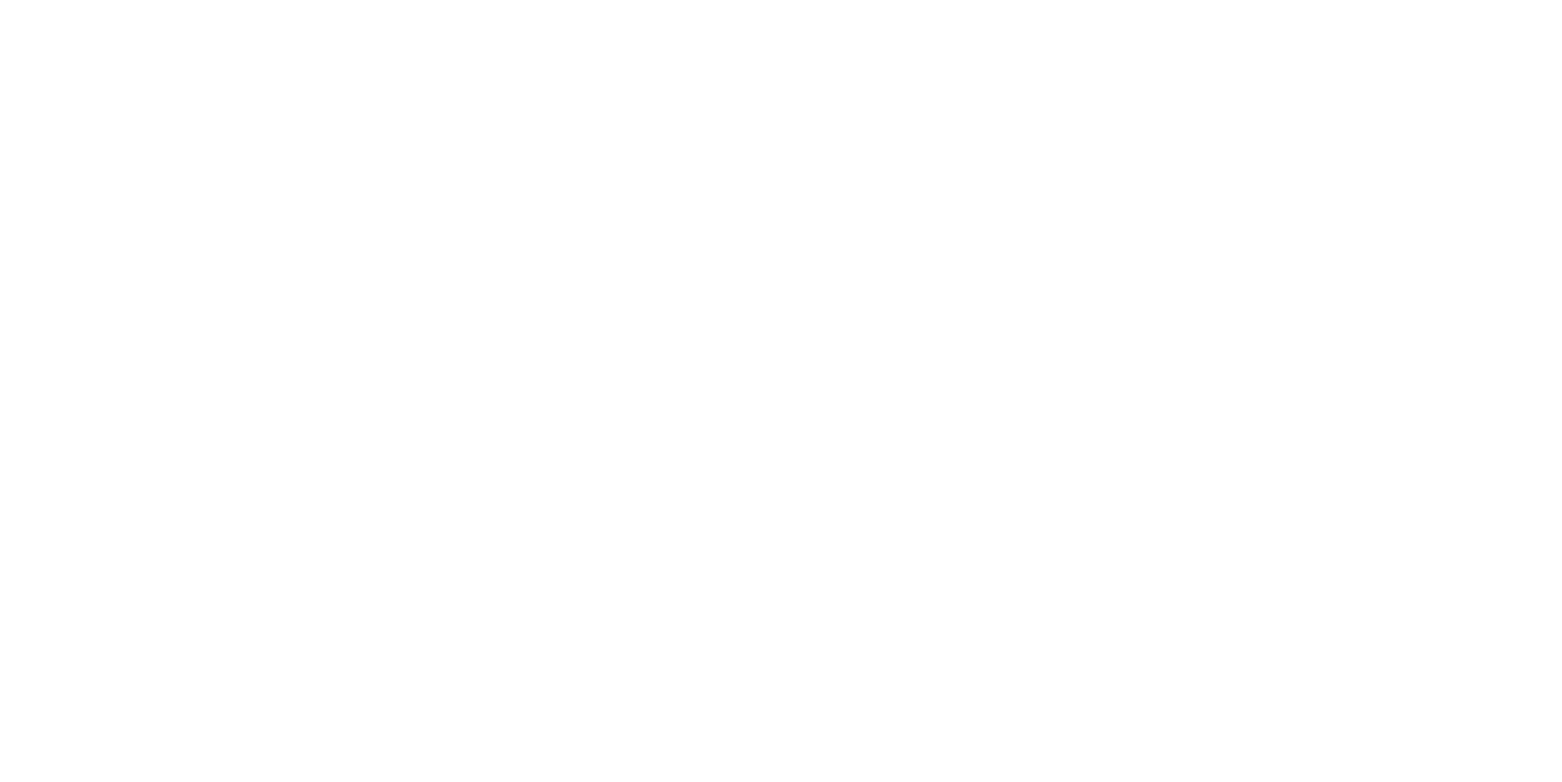

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


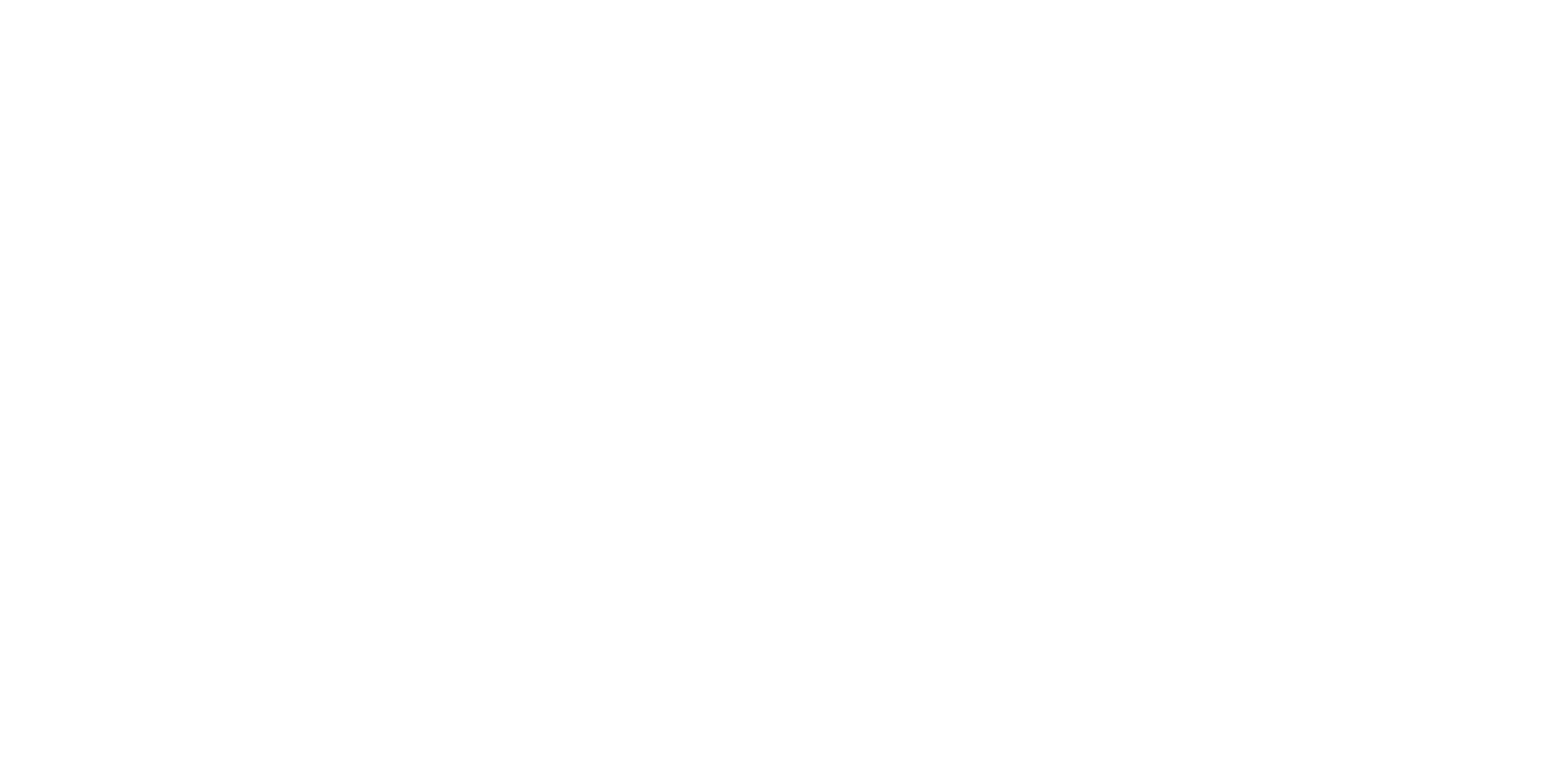

Sum of columns in precision matrix [ 1.  1. nan  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


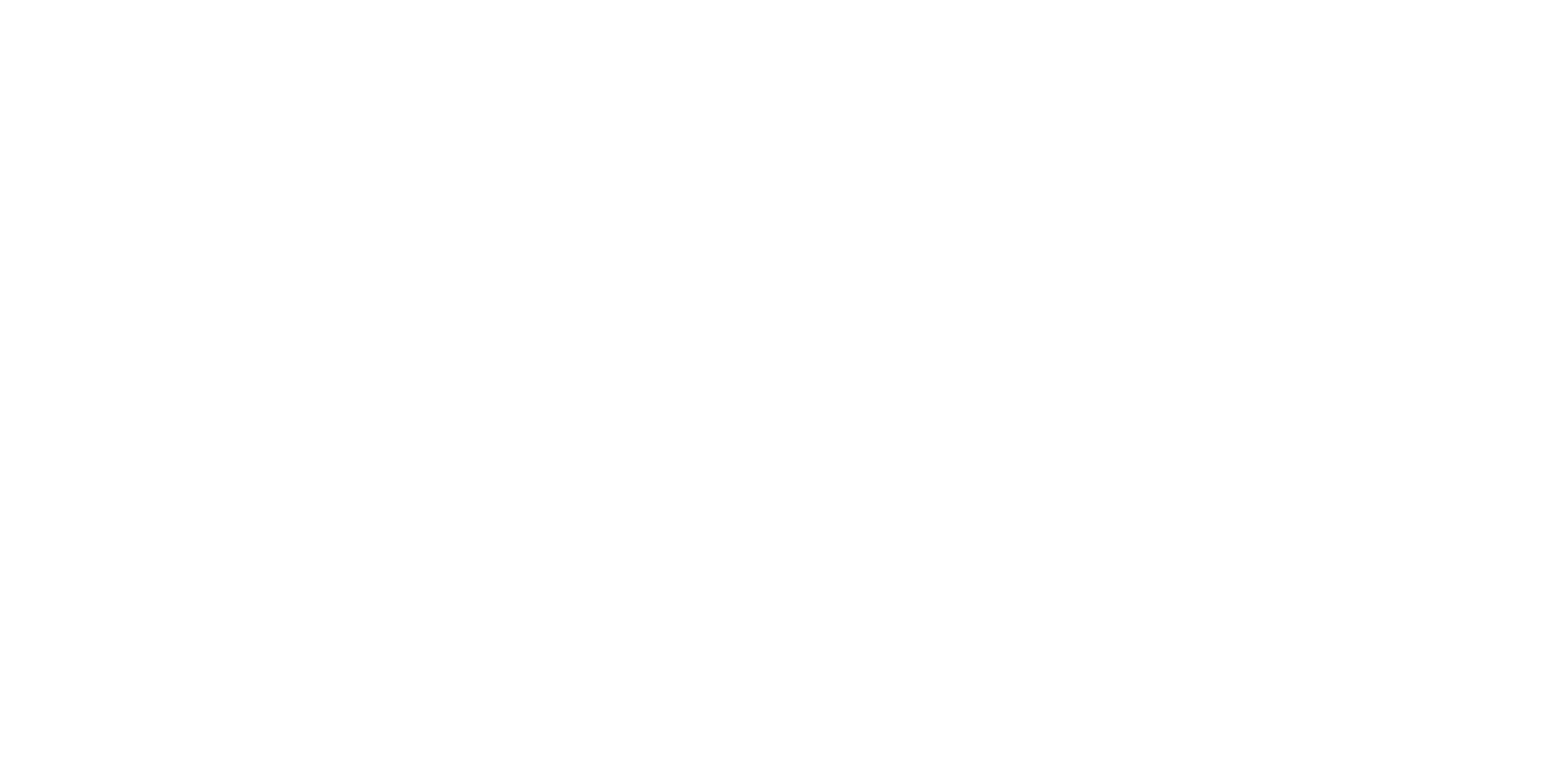

Sum of rows in precision matrix [1. 1. 1. 1.]


In [33]:
logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train_total_features,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train_total_features, y_train)

log loss for train data 0.9038859341159958
log loss for cv data 0.9037686153577275
log loss for test data 0.9037356689536634
Number of misclassified points  41.502231672804406
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


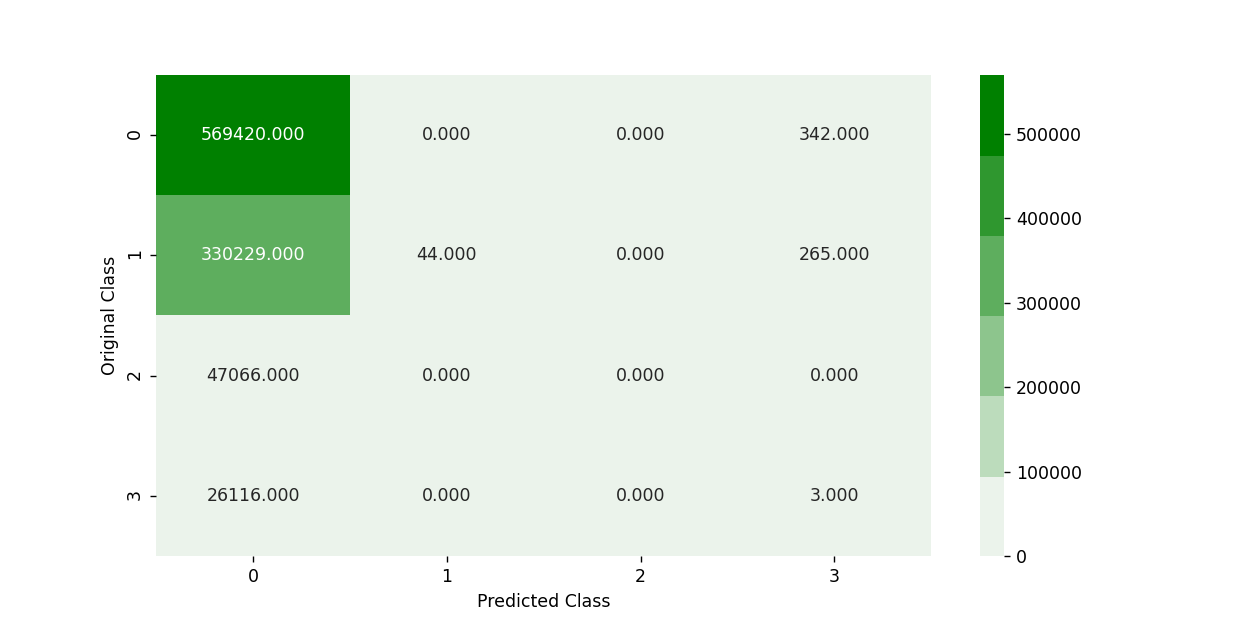

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


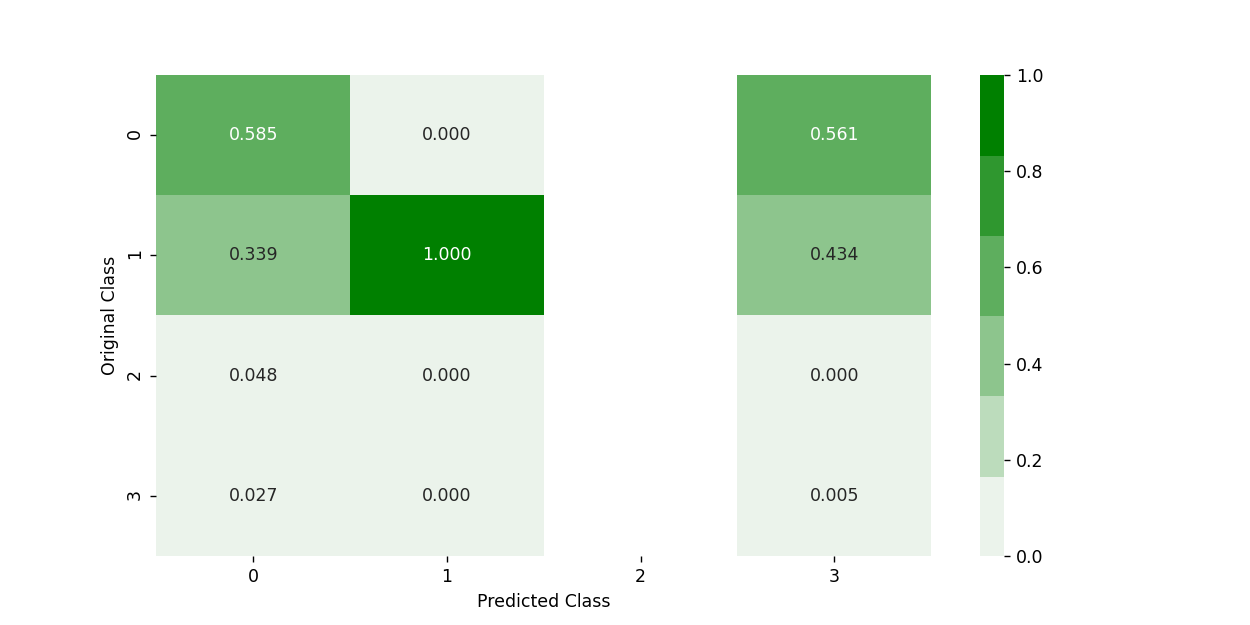

Sum of columns in precision matrix [ 1.  1. nan  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


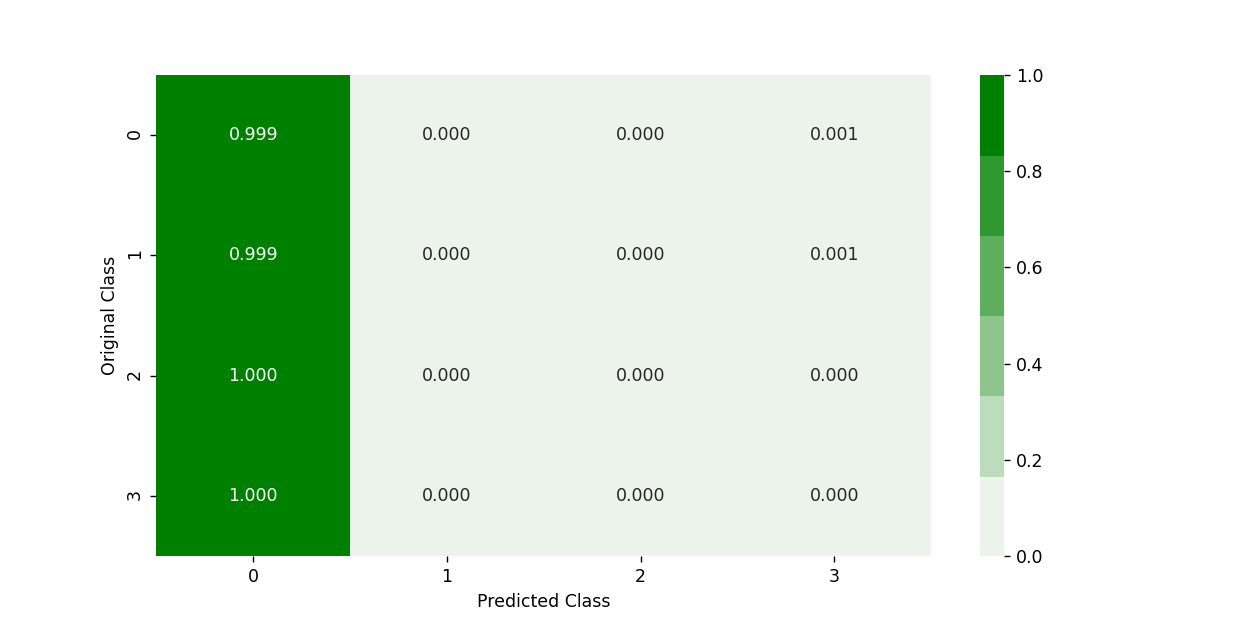

Sum of rows in precision matrix [1. 1. 1. 1.]


In [35]:
pred_y=sig_clf.predict(X_test_total_features)

predict_y = sig_clf.predict_proba(X_train_total_features)
print ('log loss for train data',log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_total_features)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_total_features)
print ('log loss for test data',log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
plot_confusion_matrix(y_test, sig_clf.predict(X_test_total_features))

In [37]:
!pip install joblib

In [40]:
#Saving the Logistic Regression Model
# https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
import joblib
   
joblib.dump(logisticR, 'logisticR.pkl')

['logisticR.pkl']

<h2>2.Stack the models </h2>

In [29]:
!pip install mlxtend

In [30]:
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import SGDClassifier

In [39]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

clf1 = SGDClassifier(alpha=0.01, penalty='l2', loss='log', random_state=0)
clf1.fit(X_train_total_features,y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha = 1, penalty='l2', loss='hinge', random_state=0)
clf2.fit(X_train_total_features,y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


sig_clf1.fit(X_train_total_features, y_train)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(y_cv, sig_clf1.predict_proba(X_cv_total_features))))
sig_clf2.fit(X_train_total_features, y_train)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(y_cv, sig_clf2.predict_proba(X_cv_total_features))))

print("-" * 50)
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i, penalty='l2')
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2], meta_classifier=lr, use_probas=True) 
    sclf.fit(X_train_total_features,y_train) 
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(y_cv, sclf.predict_proba(X_cv_total_features))))
    log_error =log_loss(y_cv, sclf.predict_proba(X_cv_total_features))
    if best_alpha > log_error:
        best_alpha = log_error
        print(best_alpha)

Logistic Regression :  Log Loss: 0.91
Support vector machines : Log Loss: 0.92
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 0.917
0.9167884939712561
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 0.914
0.913920230515816
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 0.913
0.9127136956527115
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 0.910
0.9099785464193132
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 0.909
0.9088681801194859
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 0.909
0.9088337891700757


<h3>testing the model with the best hyper parameters</h3>

In [31]:
clf1 = SGDClassifier(alpha=0.01, penalty='l2', loss='log', random_state=0)
clf1.fit(X_train_total_features,y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")
print("sig_clf1 Completed")


clf2 = SGDClassifier(alpha = 1, penalty='l2', loss='hinge', random_state=0)
clf2.fit(X_train_total_features,y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")
print("sig_clf2 Completed")


sig_clf1.fit(X_train_total_features, y_train)
sig_clf2.fit(X_train_total_features, y_train)

sig_clf1 Completed
sig_clf2 Completed


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1, random_state=0))

In [33]:
lr = LogisticRegression(C = 10)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2], meta_classifier=lr, use_probas=True)
sclf.fit(X_train_total_features,y_train)

log_error = log_loss(y_train, sclf.predict_proba(X_train_total_features))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(y_cv, sclf.predict_proba(X_cv_total_features))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(y_test, sclf.predict_proba(X_test_total_features))
print("Log loss (test) on the stacking classifier :",log_error)

Log loss (train) on the stacking classifier : 0.9098214523473553
Log loss (CV) on the stacking classifier : 0.910181326535242
Log loss (test) on the stacking classifier : 0.9098672022843382
Number of missclassified point : 0.3953486699846428


NameError: name 'sig_clf' is not defined

Number of missclassified point : 0.3953486699846428
Number of misclassified points  39.53486699846428
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


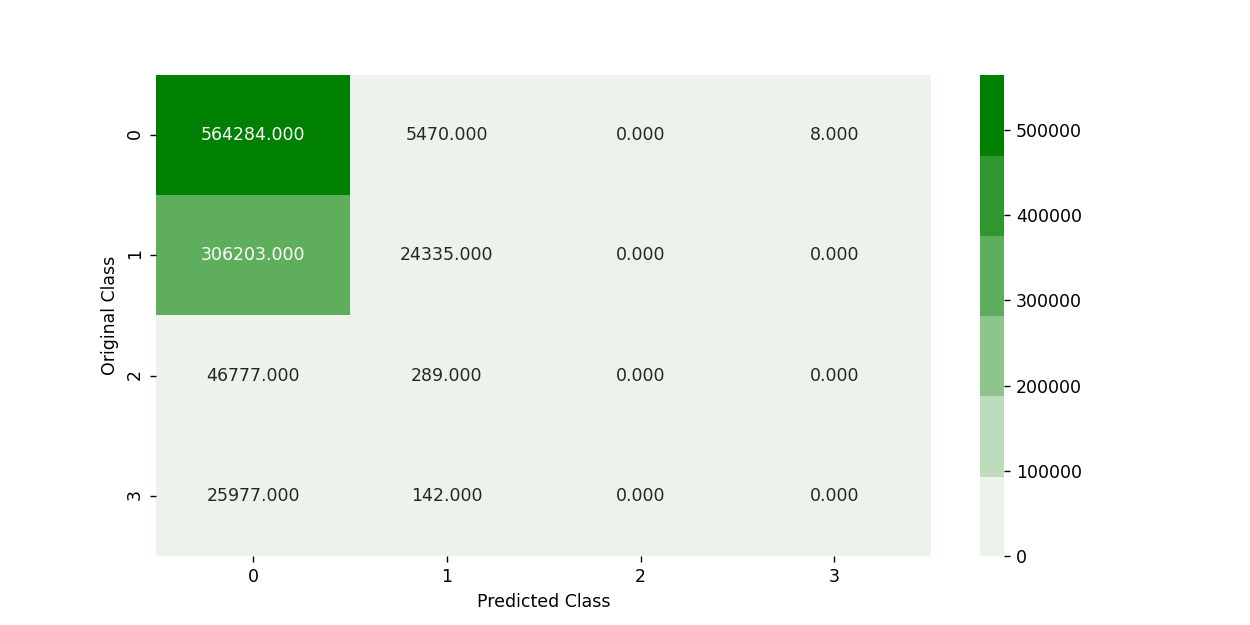

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


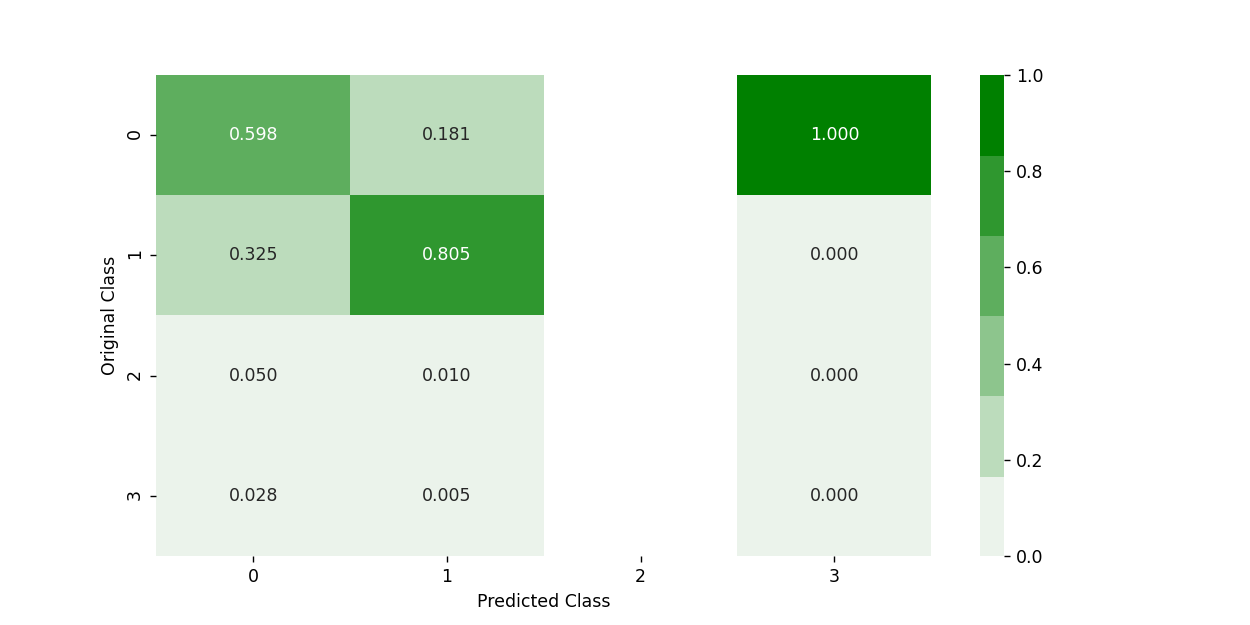

Sum of columns in precision matrix [ 1.  1. nan  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


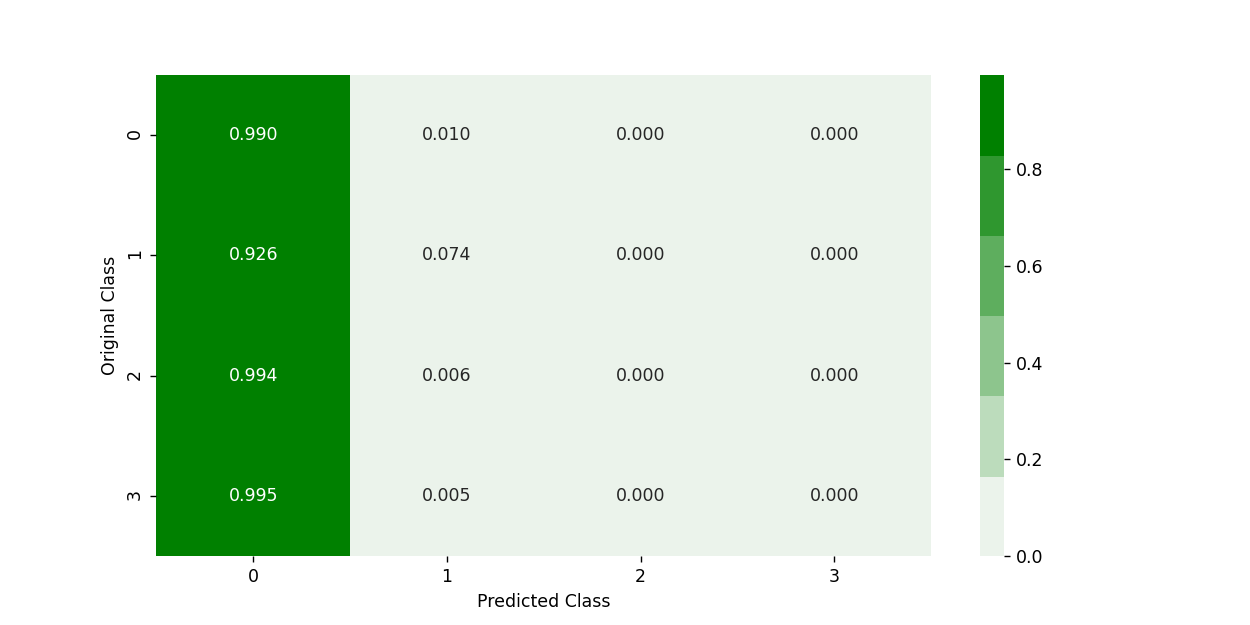

Sum of rows in precision matrix [1. 1. 1. 1.]


In [34]:
print("Number of missclassified point :", np.count_nonzero((sclf.predict(X_test_total_features)- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test, sclf.predict(X_test_total_features))

In [35]:
#Saving the Logistic Regression Model
import joblib
   
joblib.dump(sclf, 'stacking.pkl')

['stacking.pkl']

### LGBM

In [29]:
import lightgbm as lgb

In [30]:
x_cfl = lgb.LGBMClassifier()

prams={
    'learning_rate':[0.01, 0.03, 0.05, 0.15, 0.2, 0.001, 0.0001, 0.000001, 0.005, 0.0005],
    "num_leaves" : [5, 10, 15, 20, 7, 30, 100, 50, 70, 25, 40, 45, 60, 65],
     'n_estimators':[28, 24, 16, 4, 100, 40, 200, 300, 400, 500, 50, 5, 10],
     'max_depth':[3, 5, 10, 15, 25, 30, 40],
    'colsample_bytree':[0.1, 0.3, 0.5, 1, 0.4, 0.7, 0.9],
    'subsample':[0.1, 0.3, 0.5, 1, 0.4, 0.7, 0.9, 0.8],
    'min_data_in_leaf': [2, 8, 16, 25, 40, 45, 75, 100, 200]
}


random_cfl = RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs = -9)
random_cfl.fit(X_train_total_features,y_train)
random_cfl.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START colsample_bytree=0.7, learning_rate=0.2, max_depth=15, min_data_in_leaf=40, n_estimators=50, num_leaves=70, subsample=0.9
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[CV 1/5; 1/10] END colsample_bytree=0.7, learning_rate=0.2, max_depth=15, min_data_in_leaf=40, n_estimators=50, num_leaves=70, subsample=0.9; total time= 2.2min
[CV 2/5; 1/10] START colsample_bytree=0.7, learning_rate=0.2, max_depth=15, min_data_in_leaf=40, n_estimators=50, num_leaves=70, subsample=0.9
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[CV 2/5; 1/10] END colsample_bytree=0.7, learning_rate=0.2, max_depth=15, min_data_in_leaf=40, n_estimators=50, num_leaves=70, subsample=0.9; total time= 1.8min
[CV 3/5; 1/10] START colsample_bytree=0.7, learning_rate=0.2, max_depth=15, min_data_in

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[CV 5/5; 4/10] END colsample_bytree=0.4, learning_rate=0.001, max_depth=40, min_data_in_leaf=40, n_estimators=4, num_leaves=7, subsample=0.5; total time=  18.1s
[CV 1/5; 5/10] START colsample_bytree=1, learning_rate=0.2, max_depth=25, min_data_in_leaf=75, n_estimators=16, num_leaves=100, subsample=0.3
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[CV 1/5; 5/10] END colsample_bytree=1, learning_rate=0.2, max_depth=25, min_data_in_leaf=75, n_estimators=16, num_leaves=100, subsample=0.3; total time= 1.0min
[CV 2/5; 5/10] START colsample_bytree=1, learning_rate=0.2, max_depth=25, min_data_in_leaf=75, n_estimators=16, num_leaves=100, subsample=0.3
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[CV 2/5; 5/10] END colsample_

[CV 4/5; 8/10] END colsample_bytree=0.5, learning_rate=0.0001, max_depth=25, min_data_in_leaf=100, n_estimators=24, num_leaves=30, subsample=0.1; total time=  44.3s
[CV 5/5; 8/10] START colsample_bytree=0.5, learning_rate=0.0001, max_depth=25, min_data_in_leaf=100, n_estimators=24, num_leaves=30, subsample=0.1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV 5/5; 8/10] END colsample_bytree=0.5, learning_rate=0.0001, max_depth=25, min_data_in_leaf=100, n_estimators=24, num_leaves=30, subsample=0.1; total time=  45.0s
[CV 1/5; 9/10] START colsample_bytree=1, learning_rate=0.001, max_depth=30, min_data_in_leaf=40, n_estimators=40, num_leaves=65, subsample=0.4
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[CV 1/5; 9/10] END colsample_bytree=1, learning_rate=0.001, max_depth=30, min_data_in_leaf=40, n_estimators=40, num_leaves=65, subsamp

{'subsample': 0.9,
 'num_leaves': 70,
 'n_estimators': 50,
 'min_data_in_leaf': 40,
 'max_depth': 15,
 'learning_rate': 0.2,
 'colsample_bytree': 0.7}

In [31]:
random_cfl.best_params_

{'subsample': 0.9,
 'num_leaves': 70,
 'n_estimators': 50,
 'min_data_in_leaf': 40,
 'max_depth': 15,
 'learning_rate': 0.2,
 'colsample_bytree': 0.7}

In [32]:
clf=lgb.LGBMClassifier(objective="multiclass", num_classes=4, metric="multi_logloss", subsample = 0.9, num_leaves = 70, n_estimators = 50, max_depth = 15, learning_rate = 0.2, colsample_bytree = 0.7)
clf.fit(X_train_total_features,y_train)

LGBMClassifier(colsample_bytree=0.7, learning_rate=0.2, max_depth=15,
               metric='multi_logloss', n_estimators=50, num_classes=4,
               num_leaves=70, objective='multiclass', subsample=0.9)

In [33]:
predict_y = clf.predict_proba(X_train_total_features)
print ("The train log loss is: ",log_loss(y_train, predict_y))
predict_y = clf.predict_proba(X_cv_total_features)
print("The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = clf.predict_proba(X_test_total_features)
print("The test log loss is:",log_loss(y_test, predict_y))

The train log loss is:  0.05678579081324164
The cross validation log loss is: 0.05834802685572398
The test log loss is: 0.05841299248439772


In [34]:
#Saving the Logistic Regression Model
import joblib
   
joblib.dump(clf, 'lgb.pkl')

['lgb.pkl']

### Testing Data

#### Downloading Test

In [33]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/test.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1616805613&Signature=hJY7ZuH6BqS1XtZiyZSnMxc8oLGs2a7%2BzycNiY3bMNUJE7giONw8k1zHYVixgICEf6E9smhBSj4LLwXAUgbLyhDTV0URyrihllbqJe2XFhhIOD%2FoidFHoLY1pj9HLnuLKX2WYW3vXR8216OwSFGnZZIkDuQSo4%2BOefTddQ6GKHFmVfzNnfRbFmhnas1oYVuTbua3Sagd3aiqDdH46uLDd5u9MSZ8JvLr%2BBUKpPIKVY5XaWTL9L6ExNzmKELBOH71Vb6MFm730RB0Bz%2BiNlwl7gUv5RhXdBpGk2CNTuLw7TefDaG%2FqOcgMiMOH%2FhDfFFrNjsDgS7Gwa1QQGJse9iB%2Fw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest.csv.zip" -c -O 'test.csv.zip'

--2021-03-26 08:51:56--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/test.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1616805613&Signature=hJY7ZuH6BqS1XtZiyZSnMxc8oLGs2a7%2BzycNiY3bMNUJE7giONw8k1zHYVixgICEf6E9smhBSj4LLwXAUgbLyhDTV0URyrihllbqJe2XFhhIOD%2FoidFHoLY1pj9HLnuLKX2WYW3vXR8216OwSFGnZZIkDuQSo4%2BOefTddQ6GKHFmVfzNnfRbFmhnas1oYVuTbua3Sagd3aiqDdH46uLDd5u9MSZ8JvLr%2BBUKpPIKVY5XaWTL9L6ExNzmKELBOH71Vb6MFm730RB0Bz%2BiNlwl7gUv5RhXdBpGk2CNTuLw7TefDaG%2FqOcgMiMOH%2FhDfFFrNjsDgS7Gwa1QQGJse9iB%2Fw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1791131386 (1.7G) [application/zip]
Saving to: ‘test.csv.zip’

test.csv.zip      

#### Unzipping

In [34]:
import zipfile

In [35]:
#How to unizip folder: https://stackoverflow.com/questions/50714467/extract-zip-files-using-python

def unzip_folder(zip_folder, destination):
        """
        Args:
            zip_folder (string): zip folder to be unzipped
            destination (string): path of destination folder
            pwd(string): zip folder password

        """
        with zipfile.ZipFile(zip_folder) as zf:
            zf.extractall(destination)



#unzipping test
source = 'test.csv.zip'
destination = ''
unzip_folder(source, destination)

### Loading Test Data

In [4]:
# https://distributed.dask.org/en/latest/manage-computation.html
test_data1 = dd.read_csv("test.csv")
test_data1 = test_data1.compute()
# test_data1 = memory_opt(test_data1)

print("number of rows in train are {} and columns are {}".format(test_data1.shape[0], test_data1.shape[1]))

number of rows in train are 17965143 and columns are 28


In [5]:
#Looking for the top 5 rows:
test_data1.head(5)

,id,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,...,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,0,1,LOFT,0.000000,0,17.899500,6.127830,0.994807,-28.206200,-47.695499,...,-7.044480,-14.405100,-4.03384,-0.393799,31.83810,17.075600,-8.137350,-7323.120117,643.177002,594.778992
1,1,1,LOFT,0.000000,1,45.883202,94.749001,23.290800,1.392000,2.060940,...,19.887501,-215.179001,2.11832,7.340940,9.66785,1169.239990,-0.024414,-3335.080078,826.724976,136.235001
2,2,1,LOFT,0.003906,0,33.120098,28.356501,-7.239220,-7.690860,-25.833799,...,-7.642560,-10.363600,10.95050,6.513360,36.01860,24.356600,0.956158,-7323.120117,643.177002,594.778992
3,3,1,LOFT,0.003906,1,43.280102,95.887001,18.702299,-1.432890,-4.232600,...,13.826600,-214.223007,-4.91354,3.504520,3.87811,1159.400024,-0.047607,-3335.080078,826.724976,136.235001
4,4,1,LOFT,0.007812,0,7.929110,3.460380,-10.860800,-26.366699,-25.894699,...,2.045450,-20.788799,-3.61418,-7.539830,3.08397,13.647900,1.473720,-7323.120117,643.177002,594.778992


In [8]:
#Looking for the columns|features
test_data1.columns

Index(['id', 'crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7',
       'eeg_f8', 'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1',
       'eeg_p3', 'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4',
       'eeg_poz', 'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr'],
      dtype='object')

In [9]:
# https://miamioh.instructure.com/courses/38817/pages/data-cleaning#:~:text=The%20function%20dataframe.-,isnull().,
# values%20in%20the%20data%20set.&text=A%20simple%20way%20to%20deal,missing%20values%20in%20the%20dataset.

#Checking for null values in the dataset

test_data1.isnull().sum()

id            0
crew          0
experiment    0
time          0
seat          0
eeg_fp1       0
eeg_f7        0
eeg_f8        0
eeg_t4        0
eeg_t6        0
eeg_t5        0
eeg_t3        0
eeg_fp2       0
eeg_o1        0
eeg_p3        0
eeg_pz        0
eeg_f3        0
eeg_fz        0
eeg_f4        0
eeg_c4        0
eeg_p4        0
eeg_poz       0
eeg_c3        0
eeg_cz        0
eeg_o2        0
ecg           0
r             0
gsr           0
dtype: int64

In [10]:
#Checking the datatype of each variables

test_data1.dtypes

id              int64
crew            int64
experiment     object
time          float64
seat            int64
eeg_fp1       float64
eeg_f7        float64
eeg_f8        float64
eeg_t4        float64
eeg_t6        float64
eeg_t5        float64
eeg_t3        float64
eeg_fp2       float64
eeg_o1        float64
eeg_p3        float64
eeg_pz        float64
eeg_f3        float64
eeg_fz        float64
eeg_f4        float64
eeg_c4        float64
eeg_p4        float64
eeg_poz       float64
eeg_c3        float64
eeg_cz        float64
eeg_o2        float64
ecg           float64
r             float64
gsr           float64
dtype: object

### Test Data Featurizing


In [10]:
#Importing necessary Libraries


from biosppy.signals import ecg, resp, eeg
import scipy.signal as signal
from scipy.interpolate import interp1d

In [11]:
#Getting all Derived Features
def get_derived_names(f_name):
    
    derived_lst = []
    for eeg_feat in eeg_features:
        derived_lst.append(eeg_feat + f_name)
    
    return derived_lst

In [12]:
from scipy.interpolate import interp1d

#this function helps to get the Heart beat information at every Time Stamp
def interpolation_method(timestamps, bios_time, bios_rate):
    f = interp1d(bios_time, bios_rate, kind='cubic', fill_value="extrapolate")
    return f(timestamps)  #Here we get interpolated values 

In [ ]:
#applying MinMax features

#MinmaxScaling
from sklearn.preprocessing import MinMaxScaler

def min_max_features(data):  
    #creating min max object
    min_max_scaler = MinMaxScaler()
    
    #transforming
    test_data_df = min_max_scaler.fit_transform(test_data1)
    
    return test_data_df
    

In [12]:
#In this Cell we will preprocess everything we have done Like in Train Data

#Step:1 =========> Potential Differences
#Source: https://www.kaggle.com/stuartbman/introduction-to-physiological-data


features_lst = [['fp1_f7', 'eeg_fp1', 'eeg_f7'], 
                    ['f7_t3', 'eeg_f7', 'eeg_t3'], 
                    ['t3_t5', 'eeg_t3', 'eeg_t5'],
                    ['t5_o1', 'eeg_t5', 'eeg_o1'], 
                    ['fp1_f3', 'eeg_fp1', 'eeg_f7'],
                    ['f3_c3', 'eeg_f3', 'eeg_c3'],
                    ['c3_p3', 'eeg_c3', 'eeg_p3'],
                    ['p3_o1', 'eeg_p3', 'eeg_o1'],
                    ['fz_cz', 'eeg_fz', 'eeg_cz'],
                    ['cz_pz', 'eeg_cz', 'eeg_pz'],
                    ['pz_poz', 'eeg_pz', 'eeg_poz'], 
                    ['fp2_f8', 'eeg_fp2', 'eeg_f8'], 
                    ['f8_t4', 'eeg_f8', 'eeg_t4'],
                    ['t4_t6', 'eeg_t4', 'eeg_t6'],
                    ['t6_o2', 'eeg_t6', 'eeg_o2'],
                    ['fp2_f4', 'eeg_fp2', 'eeg_f4'],
                    ['f4_c4', 'eeg_f4', 'eeg_c4'],
                    ['c4_p4', 'eeg_c4', 'eeg_p4'],
                    ['p4_o2', 'eeg_p4', 'eeg_o2']]

derived_features = ['fp1_f7', 'f7_t3', 't3_t5', 't5_o1', 'fp1_f3', 'f3_c3', 'c3_p3', 'p3_o1', 'fz_cz', 'cz_pz', 'pz_poz', 'fp2_f8', 'f8_t4', 
                    't4_t6', 't6_o2', 'fp2_f4', 'f4_c4', 'c4_p4', 'p4_o2']

#This Function Helps to get all derived Features
for pair in features_lst:
    derived = pair[0]
    f1 = pair[1]
    f2 = pair[2]
    test_data1[derived] = test_data1[f1] - test_data1[f2]
    
#Step:2 ========> Getting Filtered ECG and Heart rate

#Refer this for Good Understanding: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
b, a = signal.butter(8, 100, fs = 256)
filtered_ecg = signal.filtfilt(b, a, test_data1['ecg'], padlen=150)

test_data1['filtered_ecg'] = filtered_ecg
    
# ====> Heart Rate
test_ecg = ecg.ecg(test_data1['filtered_ecg'].values, sampling_rate=256., show=False)
# print(test_ecg.keys())
result_ecg = interpolation_method(test_data1['time'], test_ecg["heart_rate_ts"], test_ecg["heart_rate"])
test_data1["ecg_rate"] = result_ecg


#Step:3 =======> Getting filtered r and Respiration rate
    
# =========> Filtered Respiration
b, a = signal.butter(5, 0.7, fs = 256)
filtered_r = signal.filtfilt(b, a, test_data1['r'], padlen=150)
test_data1['filtered_r'] = filtered_r

#=====> Respiration rate
test_respiration = resp.resp(test_data1['filtered_r'].values, sampling_rate=256., show=False)
# print(test_respiration.keys())
result_r = interpolation_method(test_data1['time'], test_respiration["resp_rate_ts"], test_respiration["resp_rate"])
test_data1["r_rate"] = result_r

features_lst = list(test_data1.columns)
# print(features_lst)

#Storing intermediate Features in Seperate Files so as to avoid ram Crashes
test_data_df  = min_max_features(test_data1)

#Converting numpy ndarray train into dataframe
test_data_df1 = pd.DataFrame(data = test_data_df,  columns = features_lst) 
test_data_df1.drop('time', axis =1, inplace =True)
test_data_df1.to_csv("bios_features1")

#Removing features that are less important and also already Stored
test_data1.drop(['crew', 'experiment', 'seat', 'id', 'ecg', 'r', 'gsr'], axis = 1, inplace = True)



#Step:4 ======> power Features
#Taking all the features of EEG into seperate list
all_features = test_data1.columns #This will give all columns in the DataSet
eeg_features = []
for feature in all_features:
    if feature[0: 2] == 'ee':
        eeg_features.append(feature)

# print(eeg_features)

    
#Getting all Features Names

#theta Names
theta_features = get_derived_names('_theta')

#high Alpha
high_alpha_features = get_derived_names('_high_alpha')

#low alpha
low_alpha_features = get_derived_names('_low_alpha')

#Beta
beta_features = get_derived_names('_beta')

#gamma
gamma_features = get_derived_names('_gamma')

# # sanity check
# print("Theta Features: ", theta_features[: 5])
# print("gamma Features: ", gamma_features[: 5])
# print("beta_features: ", beta_features[: 5])
# print("Alpha Low: ", low_alpha_features[: 5])
# print("Alpha High", high_alpha_features[: 5])

   
#getting eeg's values
power_eeg = eeg.get_power_features(test_data1[eeg_features].values, sampling_rate=256.)
#printing the keys in EEG
# power_eeg.keys()

#Getting Theta Features
theta_features_df = pd.DataFrame()
for i in range(len(eeg_features)):
    feature = theta_features[i]
    interpolate_values = interpolation_method(test_data1["time"], power_eeg["ts"], power_eeg["theta"][:, i])
    theta_features_df[feature] = interpolate_values
theta_values  = min_max_features(theta_features_df)
theta_features_df1 = pd.DataFrame(data = theta_values,  columns = theta_features) 
theta_features_df1.to_csv("theta_bios_features")


#Getting beta Features
beta_features_df = pd.DataFrame()
for i in range(len(eeg_features)):
    feature = beta_features[i]
    interpolate_values = interpolation_method(test_data1["time"], power_eeg["ts"], power_eeg["beta"][:, i])
    beta_features_df[feature] = interpolate_values
beta_values  = min_max_features(beta_features_df)
beta_features_df1 = pd.DataFrame(data = beta_values,  columns = beta_features) 
beta_features_df1.to_csv("beta_bios_features")



#Getting gamma Features
gamma_features_df = pd.DataFrame()
for i in range(len(eeg_features)):
    feature = gamma_features[i]
    interpolate_values = interpolation_method(test_data1["time"], power_eeg["ts"], power_eeg["gamma"][:, i])
    gamma_features_df[feature] = interpolate_value
gamma_values  = min_max_features(gamma_features_df)
gamma_features_df1 = pd.DataFrame(data = gamma_values,  columns = gamma_features) 
gamma_features_df1.to_csv("gamma_bios_features")



#getting alpha Low Features
alpha_low_features_df = pd.DataFrame()
for i in range(len(eeg_features)):
    feature = low_alpha_features[i]
    interpolate_values = interpolation_method(test_data1["time"], power_eeg["ts"], power_eeg["alpha_low"][:, i])
    alpha_low_features_df[feature] = interpolate_values
alpha_low_values  = min_max_features(alpha_low_features_df)
alpha_low_features_df1 = pd.DataFrame(data = alpha_low_values,  columns = low_alpha_features) 
alpha_low_features_df1.to_csv("alpha_low_bios_features")



#getting high alpha 
alpha_high_features_df = pd.DataFrame()
for i in range(len(eeg_features)):
    feature = high_alpha_features[i] 
    interpolate_values = interpolation_method(test_data1["time"], power_eeg["ts"], power_eeg["alpha_high"][:, i])
    alpha_high_features_df[feature] = interpolate_values
alpha_high_values  = min_max_features(alpha_high_features_df)
alpha_high_features_df1 = pd.DataFrame(data = alpha_high_values,  columns = high_alpha_features) 
alpha_high_features_df1.to_csv("alpha_high_bios_features")


#

In [4]:
#Loading Encoder Model
from tensorflow.keras.models import load_model
encoder = load_model('finalencoder_compression.h5')

In [5]:
#Merging all previous features with the new Encoded Features

#first Getting all features names

encoded_features_names = []

for i in range(20):
    feature_name = 'encoded' + str(i + 1)
    encoded_features_names.append(feature_name)

print(encoded_features_names)

['encoded1', 'encoded2', 'encoded3', 'encoded4', 'encoded5', 'encoded6', 'encoded7', 'encoded8', 'encoded9', 'encoded10', 'encoded11', 'encoded12', 'encoded13', 'encoded14', 'encoded15', 'encoded16', 'encoded17', 'encoded18', 'encoded19', 'encoded20']


In [8]:
import pandas as pd

bios_feat = pd.read_csv("bios_features1", chunksize = 200000)

theta_features = pd.read_csv("theta_bios_features", chunksize = 200000)
beta_fearures = pd.read_csv('beta_bios_features', chunksize = 200000)
gamma_features = pd.read_csv('gamma_bios_features', chunksize = 200000)
lowalpha_features = pd.read_csv('alpha_low_bios_features', chunksize = 200000)
highalpha_features = pd.read_csv('alpha_high_bios_features', chunksize = 200000)

In [9]:
encoders_lst = []  

i = 0
# Each chunk is in dataframe format
for bios_df, theta_df, beta_df, gamma_df, low_df, high_df in zip(bios_feat,theta_features,beta_fearures,gamma_features,lowalpha_features,highalpha_features):
    bios_df.drop('Unnamed: 0', axis = 1, inplace = True)
    bios_df.reset_index(drop = True, inplace = True)
    theta_df.drop('Unnamed: 0', axis = 1, inplace = True)
    theta_df.reset_index(drop = True, inplace = True)
    beta_df.drop('Unnamed: 0', axis = 1, inplace = True)
    beta_df.reset_index(drop = True, inplace = True)
    gamma_df.drop('Unnamed: 0', axis = 1, inplace = True)
    gamma_df.reset_index(drop = True, inplace = True)
    low_df.drop('Unnamed: 0', axis = 1, inplace = True)
    low_df.reset_index(drop = True, inplace = True)
    high_df.drop('Unnamed: 0', axis = 1, inplace = True)
    high_df.reset_index(drop = True, inplace = True)
    
    
    total_test = pd.concat([bios_df, theta_df, beta_df, gamma_df, low_df, high_df], axis = 1)
    encoded_values = encoder.predict(total_test)
    encoders_lst.append(encoded_values)
    i += 1
    
    if i == 10:
        print("Completed: Batch")
        i = 0

Completed: Batch
Completed: Batch
Completed: Batch
Completed: Batch
Completed: Batch
Completed: Batch
Completed: Batch
Completed: Batch
Completed: Batch


In [12]:
  
# dictionary of lists
    
encoded_df = pd.DataFrame(data = encoders_lst[0],  columns = encoded_features_names)
encoded_df.reset_index(drop = True, inplace = True)

encoded_df.head()

,encoded1,encoded2,encoded3,encoded4,encoded5,encoded6,encoded7,encoded8,encoded9,encoded10,encoded11,encoded12,encoded13,encoded14,encoded15,encoded16,encoded17,encoded18,encoded19,encoded20
0,-0.011422,-0.119841,-0.019026,-0.018384,-0.097058,-0.031384,0.013323,0.106172,-0.011587,0.068519,0.006311,0.121539,-0.006447,0.109003,-0.037404,-0.022530,0.024951,-0.017161,0.070818,-0.090283
1,-0.062377,-0.078064,-0.092101,0.049207,-0.118906,-0.095217,0.011958,0.131129,-0.015396,0.089496,-0.021108,0.089458,-0.003569,0.034599,-0.054416,0.013025,0.030435,-0.047659,0.096219,-0.100108
2,-0.009860,-0.120352,-0.019297,-0.018919,-0.098774,-0.031338,0.013658,0.104304,-0.011329,0.067342,0.006295,0.123816,-0.005847,0.106064,-0.037593,-0.023985,0.025425,-0.018871,0.069694,-0.090542
3,-0.063437,-0.077415,-0.093530,0.049069,-0.118670,-0.095160,0.012245,0.131096,-0.015720,0.088534,-0.020759,0.088787,-0.002956,0.033990,-0.055124,0.013036,0.030453,-0.048546,0.095420,-0.101160
4,-0.006479,-0.120346,-0.021842,-0.022614,-0.103064,-0.029496,0.017483,0.104715,-0.010334,0.065668,0.008845,0.121949,-0.004597,0.105685,-0.035125,-0.029342,0.025661,-0.021021,0.070310,-0.088676


In [14]:
j = 0
for i in range(1, 90):
    sub_encoded_df = pd.DataFrame(data = encoders_lst[i],  columns = encoded_features_names)
    sub_encoded_df.reset_index(drop = True, inplace = True)
    encoded_df = pd.concat([encoded_df, sub_encoded_df], axis = 0)    
    j += 1
    if j == 10:
        print("Completed: Batch")
        j = 0

Completed: Batch
Completed: Batch
Completed: Batch
Completed: Batch
Completed: Batch
Completed: Batch
Completed: Batch
Completed: Batch


In [15]:
encoded_df.shape

(17965143, 20)

In [17]:
encoded_df.reset_index(drop = True, inplace = True)

In [20]:
encoded_df.to_csv("encoders_features")

### Predictions

##### Logistic Regression

In [7]:
import joblib

In [31]:
logistic_model = joblib.load('logisticR.pkl')

In [ ]:
logistic_model

In [9]:
import pandas as pd

bios_feat = pd.read_csv("bios_features1", chunksize = 200000)

theta_features = pd.read_csv("theta_bios_features", chunksize = 200000)
beta_fearures = pd.read_csv('beta_bios_features', chunksize = 200000)
gamma_features = pd.read_csv('gamma_bios_features', chunksize = 200000)
lowalpha_features = pd.read_csv('alpha_low_bios_features', chunksize = 200000)
highalpha_features = pd.read_csv('alpha_high_bios_features', chunksize = 200000)
encoded_features = pd.read_csv('encoders_features', chunksize = 200000)


In [35]:
predictions = []  

i = 0
# Each chunk is in dataframe format
for bios_df, theta_df, beta_df, gamma_df, low_df, high_df, encoded_df in zip(bios_feat,theta_features,beta_fearures,gamma_features,lowalpha_features, highalpha_features, encoded_features):
    bios_df.drop('Unnamed: 0', axis = 1, inplace = True)
    bios_df.reset_index(drop = True, inplace = True)
    theta_df.drop('Unnamed: 0', axis = 1, inplace = True)
    theta_df.reset_index(drop = True, inplace = True)
    beta_df.drop('Unnamed: 0', axis = 1, inplace = True)
    beta_df.reset_index(drop = True, inplace = True)
    gamma_df.drop('Unnamed: 0', axis = 1, inplace = True)
    gamma_df.reset_index(drop = True, inplace = True)
    low_df.drop('Unnamed: 0', axis = 1, inplace = True)
    low_df.reset_index(drop = True, inplace = True)
    high_df.drop('Unnamed: 0', axis = 1, inplace = True)
    high_df.reset_index(drop = True, inplace = True)
    encoded_df.drop('Unnamed: 0', axis = 1, inplace = True)
    encoded_df.reset_index(drop = True, inplace = True)
    
    
    total_test = pd.concat([bios_df, theta_df, beta_df, gamma_df, low_df, high_df, encoded_df], axis = 1)
    predictions_values = logistic_model.predict_proba(total_test)
    predictions.append(predictions_values)
    i += 1
    
    if i == 10:
        print("Batch : Completed")
        i = 0

Batch : Completed
Batch : Completed
Batch : Completed
Batch : Completed
Batch : Completed
Batch : Completed
Batch : Completed
Batch : Completed
Batch : Completed


In [36]:
lst_A = []

for i in range(0, 90):
    lst_A.extend(predictions[i][:, 0])

lst_B = []

for i in range(0, 90):
    lst_B.extend(predictions[i][:, 1])
    
lst_C = []

for i in range(0, 90):
    lst_C.extend(predictions[i][:, 2])
    
lst_D = []
for i in range(0, 90):
    lst_D.extend(predictions[i][:, 3])

In [37]:
#Checking whether the number of Rows are Correct or not
print(len(lst_A))
print(len(lst_B))
print(len(lst_C))
print(len(lst_D))

17965143
17965143
17965143
17965143


In [38]:
#Getting Id Values
id_values = []
for i in range(0, 17965143):
    id_values.append(i)

In [39]:
  
# dictionary of lists 
predictions_dict = {'id': id_values, 'A': lst_A, 'B': lst_B, 'C': lst_C, 'D': lst_D} 
    
predictions_df = pd.DataFrame(predictions_dict)
    
predictions_df.head()

,id,A,B,C,D
0,0,0.263470,0.153220,0.438639,0.144672
1,1,0.254696,0.121699,0.459736,0.163868
2,2,0.262852,0.152153,0.440234,0.144762
3,3,0.255440,0.122613,0.459407,0.162540
4,4,0.261543,0.148948,0.444837,0.144672


In [40]:
predictions_df.to_csv('logistic_predict_final.gz', compression='gzip', index = False)

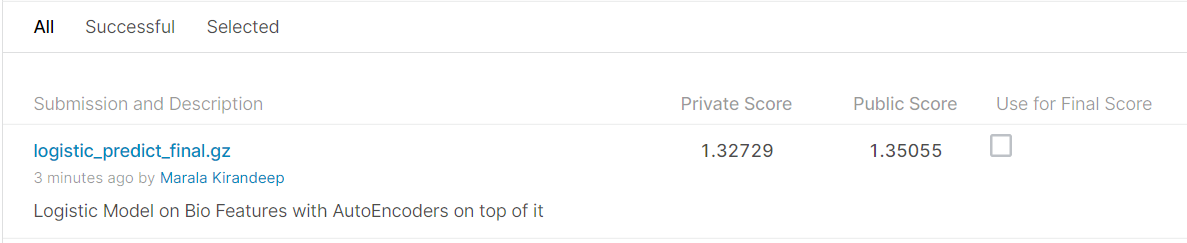

#### Stacking

In [10]:
stacking_model = joblib.load('stacking.pkl')

In [11]:
predictions = []  

i = 0
# Each chunk is in dataframe format
for bios_df, theta_df, beta_df, gamma_df, low_df, high_df, encoded_df in zip(bios_feat,theta_features,beta_fearures,gamma_features,lowalpha_features, highalpha_features, encoded_features):
    bios_df.drop('Unnamed: 0', axis = 1, inplace = True)
    bios_df.reset_index(drop = True, inplace = True)
    theta_df.drop('Unnamed: 0', axis = 1, inplace = True)
    theta_df.reset_index(drop = True, inplace = True)
    beta_df.drop('Unnamed: 0', axis = 1, inplace = True)
    beta_df.reset_index(drop = True, inplace = True)
    gamma_df.drop('Unnamed: 0', axis = 1, inplace = True)
    gamma_df.reset_index(drop = True, inplace = True)
    low_df.drop('Unnamed: 0', axis = 1, inplace = True)
    low_df.reset_index(drop = True, inplace = True)
    high_df.drop('Unnamed: 0', axis = 1, inplace = True)
    high_df.reset_index(drop = True, inplace = True)
    encoded_df.drop('Unnamed: 0', axis = 1, inplace = True)
    encoded_df.reset_index(drop = True, inplace = True)
    
    
    total_test = pd.concat([bios_df, theta_df, beta_df, gamma_df, low_df, high_df, encoded_df], axis = 1)
    predictions_values = stacking_model.predict_proba(total_test)
    predictions.append(predictions_values)
    i += 1
    
    if i == 10:
        print("Batch : Completed")
        i = 0

Batch : Completed
Batch : Completed
Batch : Completed
Batch : Completed
Batch : Completed
Batch : Completed
Batch : Completed
Batch : Completed
Batch : Completed


In [12]:
lst_A = []

for i in range(0, 90):
    lst_A.extend(predictions[i][:, 0])

lst_B = []

for i in range(0, 90):
    lst_B.extend(predictions[i][:, 1])
    
lst_C = []

for i in range(0, 90):
    lst_C.extend(predictions[i][:, 2])
    
lst_D = []
for i in range(0, 90):
    lst_D.extend(predictions[i][:, 3])

In [13]:
print(len(lst_A))
print(len(lst_B))
print(len(lst_C))
print(len(lst_D))

17965143
17965143
17965143
17965143


In [14]:
#Getting Id Values
id_values = []
for i in range(0, 17965143):
    id_values.append(i)

In [15]:
  
# dictionary of lists 
predictions_dict = {'id': id_values, 'A': lst_A, 'B': lst_B, 'C': lst_C, 'D': lst_D} 
    
predictions_df = pd.DataFrame(predictions_dict)
    
predictions_df.head()

,id,A,B,C,D
0,0,0.710495,0.046976,0.084782,0.157748
1,1,0.749388,0.063682,0.086091,0.100839
2,2,0.717382,0.055417,0.083627,0.143574
3,3,0.748737,0.058490,0.086772,0.106001
4,4,0.726978,0.058002,0.082290,0.132730


In [16]:
predictions_df.to_csv('stacking_predict_final.gz', compression='gzip', index = False)

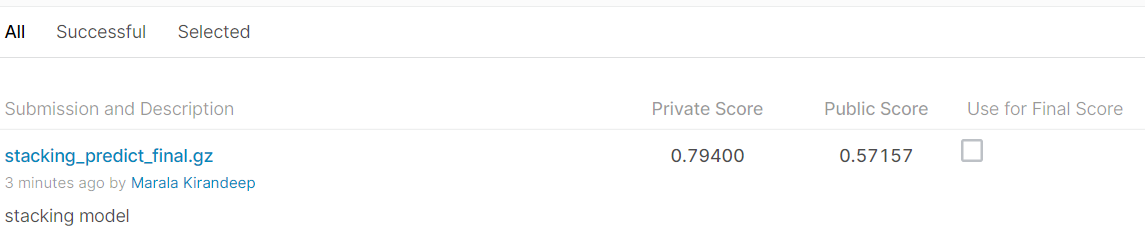

##### LightGBM Model

In [5]:
import joblib

In [6]:
lgb_model = joblib.load('lgb.pkl')

In [7]:
lgb_model

LGBMClassifier(colsample_bytree=0.7, learning_rate=0.2, max_depth=15,
               metric='multi_logloss', n_estimators=50, num_classes=4,
               num_leaves=70, objective='multiclass', subsample=0.9)

In [10]:
predictions = []  

i = 0
# Each chunk is in dataframe format
for bios_df, theta_df, beta_df, gamma_df, low_df, high_df, encoded_df in zip(bios_feat,theta_features,beta_fearures,gamma_features,lowalpha_features, highalpha_features, encoded_features):
    bios_df.drop('Unnamed: 0', axis = 1, inplace = True)
    bios_df.reset_index(drop = True, inplace = True)
    theta_df.drop('Unnamed: 0', axis = 1, inplace = True)
    theta_df.reset_index(drop = True, inplace = True)
    beta_df.drop('Unnamed: 0', axis = 1, inplace = True)
    beta_df.reset_index(drop = True, inplace = True)
    gamma_df.drop('Unnamed: 0', axis = 1, inplace = True)
    gamma_df.reset_index(drop = True, inplace = True)
    low_df.drop('Unnamed: 0', axis = 1, inplace = True)
    low_df.reset_index(drop = True, inplace = True)
    high_df.drop('Unnamed: 0', axis = 1, inplace = True)
    high_df.reset_index(drop = True, inplace = True)
    encoded_df.drop('Unnamed: 0', axis = 1, inplace = True)
    encoded_df.reset_index(drop = True, inplace = True)
    
    
    total_test = pd.concat([bios_df, theta_df, beta_df, gamma_df, low_df, high_df, encoded_df], axis = 1)
    predictions_values = lgb_model.predict_proba(total_test)
    predictions.append(predictions_values)
    i += 1
    
    if i == 10:
        print("Batch : Completed")
        i = 0

Batch : Completed
Batch : Completed
Batch : Completed
Batch : Completed
Batch : Completed
Batch : Completed
Batch : Completed
Batch : Completed
Batch : Completed


In [11]:
lst_A = []

for i in range(0, 90):
    lst_A.extend(predictions[i][:, 0])

lst_B = []

for i in range(0, 90):
    lst_B.extend(predictions[i][:, 1])
    
lst_C = []

for i in range(0, 90):
    lst_C.extend(predictions[i][:, 2])
    
lst_D = []
for i in range(0, 90):
    lst_D.extend(predictions[i][:, 3])

In [12]:
print(len(lst_A))
print(len(lst_B))
print(len(lst_C))
print(len(lst_D))

17965143
17965143
17965143
17965143


In [13]:
#Getting Id Values
id_values = []
for i in range(0, 17965143):
    id_values.append(i)

In [24]:
  
# dictionary of lists 
predictions_dict = {'id': id_values, 'A': lst_A, 'B': lst_B, 'C': lst_C, 'D': lst_D} 
    
predictions_df = pd.DataFrame(predictions_dict)
    
predictions_df.head()

,id,A,B,C,D
0,0,0.994710,0.003383,0.001338,0.000569
1,1,0.996325,0.003331,0.000260,0.000083
2,2,0.994459,0.003624,0.001434,0.000483
3,3,0.996325,0.003331,0.000260,0.000083
4,4,0.994110,0.003832,0.001448,0.000610


In [29]:
predictions_df.to_csv('lgb_predict_final.gz', compression='gzip', index = False)

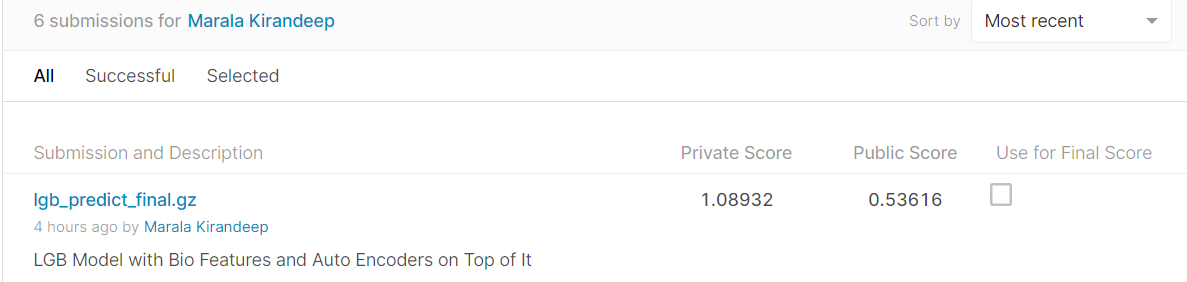